In [1]:
import os
import glob
import time
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report 

In [5]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


# Data Load & Labeling

In [6]:
def Load_Labeling(file, cancer_list):
    download_path = os.getcwd() + f'/{file}'
    path_list = os.listdir(download_path)
    path_list = [x for x in path_list if x != '.ipynb_checkpoints']
    cancer_df = pd.DataFrame()
    for idx, f in enumerate(path_list):
        cancer = cancer_list[idx] # Load cancer
        cancer_txt = ''.join([f for f in path_list if f[:4] == cancer])
        print(f'cancer : {cancer}\nfile : {cancer_txt}') 
        # file load
        data = pd.read_csv(f'{download_path}/{cancer_txt}', sep='\t', low_memory=False, index_col='Hybridization REF', skiprows=[1])
        data = data.transpose()
        # Separation of cancer patients 
        data['Target'] = data.index.str[13:15]
        data['Target'] = data['Target'].replace({'01':'cancer', '02':'cancer', '11':'Normal', '10':'Normal'})
        data['Target'] = cancer +'_'+ data['Target']
        data = data[data['Target'].str.contains('cancer')]
        cancer_df = pd.concat([cancer_df, data])
    # cancer data labeling
    cancer_df = pd.get_dummies(cancer_df, columns=['Target'], drop_first=True)
    cancer_df.rename(columns = {f'Target_{cancer}_cancer': cancer}, inplace=True)
    return cancer_df

In [7]:
path = '/gdrive/MyDrive/genome_data' 
genome_list = ['LUAD', 'LUSC'] # cancer
df = Load_Labeling(path, genome_list)

cancer : LUAD
file : LUAD.rnaseqv2__illuminahiseq_rnaseqv2__unc_edu__Level_3__RSEM_genes_normalized__data.data.txt
cancer : LUSC
file : LUSC.rnaseqv2__illuminahiseq_rnaseqv2__unc_edu__Level_3__RSEM_genes_normalized__data.data.txt


In [8]:
df

,?|100130426,?|100133144,?|100134869,?|10357,?|10431,?|136542,?|155060,?|26823,?|280660,?|317712,...,ZXDB|158586,ZXDC|79364,ZYG11A|440590,ZYG11B|79699,ZYX|7791,ZZEF1|23140,ZZZ3|26009,psiTPTE22|387590,tAKR|389932,LUSC
TCGA-05-4244-01A-01R-1107-07,0.0,10.0113,11.2820,49.5994,848.9397,0.0,345.2308,1.0472,0.0000,0.0,...,292.5212,959.2460,0.6981,1088.0531,2837.9440,871.2802,575.2683,6.6323,0.0000,0
TCGA-05-4249-01A-01R-1107-07,0.0,7.1957,12.4436,90.5117,924.0158,0.0,145.2025,1.6098,0.0000,0.0,...,493.5597,1179.3275,20.2833,787.5061,2351.2500,1138.1170,690.2752,179.9738,0.0000,0
TCGA-05-4250-01A-01R-1107-07,0.0,7.2453,6.0184,49.5366,1140.6781,0.0,51.7284,0.0000,0.0000,0.0,...,365.4149,843.9028,26.5274,475.1720,5437.4534,1170.5214,532.8691,6.3003,0.0000,0
TCGA-05-4382-01A-01R-1206-07,0.0,11.3311,7.5740,82.8303,807.1729,0.0,240.0221,0.4786,0.2393,0.0,...,346.7517,946.6872,64.8514,908.1593,6770.1537,1169.2401,663.8297,35.1777,0.0000,0
TCGA-05-4384-01A-01R-1755-07,0.0,3.2254,3.4942,72.5351,562.0037,0.0,274.2822,0.6109,0.0000,0.0,...,563.2254,1320.7086,7.9414,778.8638,3341.4783,1737.3244,723.2743,378.1307,0.0000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TCGA-O2-A52S-01A-11R-A262-07,0.0,19.9503,47.1026,176.7177,1188.3278,0.0,226.8212,1.6556,0.0000,0.0,...,507.4503,1392.7980,126.2417,580.2980,2681.7053,1069.5364,783.1126,5.3808,1.2417,1
TCGA-O2-A52V-01A-31R-A262-07,0.0,30.0872,15.2957,188.7215,1248.0303,0.0,147.4945,0.4202,0.0000,0.0,...,366.8453,1326.6099,6.3032,845.8872,6094.3376,663.9353,778.6532,2.1011,0.0000,1
TCGA-O2-A52W-01A-11R-A26W-07,0.0,53.6593,33.3907,260.3332,789.3606,0.0,854.3794,0.0000,0.0000,0.0,...,336.9156,2002.6867,101.5583,613.6486,2560.9887,730.2526,761.9559,12.3589,0.0000,1
TCGA-O2-A5IB-01A-11R-A27Q-07,0.0,72.5666,42.1832,160.1624,460.8626,0.0,569.2226,1.3312,0.0000,0.0,...,584.1321,2074.5474,150.4260,1155.2183,1185.0373,833.3333,1383.1203,1.0650,0.0000,1


# Classifier model 

In [9]:
feautre = df.iloc[:,:-1]
target = df['LUSC']
# train_test_split
x_train, x_test, y_train, y_test = train_test_split(feautre, target, test_size=0.2, stratify=target, random_state=20) #stratufy 옵션을 통해 class 비율 유지
print(f'train: {x_train.shape}, {y_train.shape} test: {x_test.shape}, {y_test.shape}\n')
print("training label 빈도:\n", pd.DataFrame(y_train).value_counts(), sep="", end="\n\n")
print("test label 빈도:\n", pd.DataFrame(y_test).value_counts(), sep="")

train: (814, 20531), (814,) test: (204, 20531), (204,)

training label 빈도:
LUSC
0       413
1       401
dtype: int64

test label 빈도:
LUSC
0       104
1       100
dtype: int64


In [11]:
def ClassModel(model):
  start_time = time.time()
  class_model = test_model[model]
  class_model.fit(x_train, y_train)
  y_pred = class_model.predict(x_test)

  print(f'{model} Accuracy : {accuracy_score(y_test, y_pred)}')
  print(classification_report(y_test, y_pred))
  print(f'\nTime : {time.time() - start_time}')
  return class_model

In [10]:
model_name = ['EXT','GB']
test_model = {
    'EXT' : ExtraTreesClassifier(random_state=20),
    'GB' : GradientBoostingClassifier(random_state=20)
  }

In [15]:
m = ClassModel(model_name[0])

EXT Accuracy : 0.9509803921568627
              precision    recall  f1-score   support

           0       0.94      0.97      0.95       104
           1       0.97      0.93      0.95       100

    accuracy                           0.95       204
   macro avg       0.95      0.95      0.95       204
weighted avg       0.95      0.95      0.95       204


Time : 1.5983126163482666


In [16]:
m = ClassModel(model_name[1])

GB Accuracy : 0.9656862745098039
              precision    recall  f1-score   support

           0       0.94      0.99      0.97       104
           1       0.99      0.94      0.96       100

    accuracy                           0.97       204
   macro avg       0.97      0.97      0.97       204
weighted avg       0.97      0.97      0.97       204


Time : 335.940767288208


In [1]:
# modeling
EXT = ExtraTreesClassifier()

params = {
    'min_samples_split' : [2, 3, 4, 6],
    'n_estimators' : [100, 500, 800, 1000, 1500],
    'criterion' : ['gini', 'entropy', 'log_loss'],
    'max_features' : ['sqrt', 'log2', 'None']
}

EXT_grid = GridSearchCV(estimator=EXT, param_grid=params, cv=2, refit=True) 
EXT_grid.fit(x_train, y_train)

In [18]:
scores_df = pd.DataFrame(EXT_grid.cv_results_)
scores_df[['params', 'mean_test_score', 'rank_test_score', 
           'split0_test_score', 'split1_test_score']]

,params,mean_test_score,rank_test_score,split0_test_score,split1_test_score
0,"{'criterion': 'gini', 'max_features': 'sqrt', ...",0.943489,31,0.941032,0.945946
1,"{'criterion': 'gini', 'max_features': 'sqrt', ...",0.944717,17,0.938575,0.950860
2,"{'criterion': 'gini', 'max_features': 'sqrt', ...",0.943489,31,0.936118,0.950860
3,"{'criterion': 'gini', 'max_features': 'sqrt', ...",0.942260,54,0.936118,0.948403
4,"{'criterion': 'gini', 'max_features': 'sqrt', ...",0.942260,54,0.936118,0.948403
...,...,...,...,...,...
175,"{'criterion': 'log_loss', 'max_features': 'Non...",NaN,108,NaN,NaN
176,"{'criterion': 'log_loss', 'max_features': 'Non...",NaN,107,NaN,NaN
177,"{'criterion': 'log_loss', 'max_features': 'Non...",NaN,106,NaN,NaN
178,"{'criterion': 'log_loss', 'max_features': 'Non...",NaN,134,NaN,NaN


In [19]:
print(f"Optimal Parameters : {EXT_grid.best_params_}")
print(f"Accuracy of optimal parameters : {EXT_grid.best_score_}")

Optimal Parameters : {'criterion': 'entropy', 'max_features': 'log2', 'min_samples_split': 2, 'n_estimators': 1000}
Accuracy of optimal parameters : 0.9484029484029484


In [20]:
EXT_model = EXT_grid.best_estimator_
y_pred = EXT_model.predict(x_test)
print(f' Accuracy : {accuracy_score(y_test, y_pred)}')
print(classification_report(y_test, y_pred))

 Accuracy : 0.946078431372549
              precision    recall  f1-score   support

           0       0.93      0.97      0.95       104
           1       0.97      0.92      0.94       100

    accuracy                           0.95       204
   macro avg       0.95      0.95      0.95       204
weighted avg       0.95      0.95      0.95       204



# Feature importance

In [21]:
# feature importances
EXT_importances = EXT_model.feature_importances_
# ranking
rank_idx = EXT_importances.argsort()[::-1] 
topDf = pd.DataFrame(EXT_importances[rank_idx], index=x_train.columns[rank_idx], columns=['Top Biomarker']).iloc[:10]
topDf

,Top Biomarker
PVRL1|5818,0.001377
SLC2A1|6513,0.001212
TRIM29|23650,0.001199
RGL3|57139,0.001106
LOC100129034|100129034,0.001082
PCYT1A|5130,0.001056
DDAH1|23576,0.000985
BCL2L15|440603,0.000884
JAG1|182,0.000874
ZNF436|80818,0.000842


In [22]:
topDf[::-1]['Top Biomarker']

ZNF436|80818              0.000842
JAG1|182                  0.000874
BCL2L15|440603            0.000884
DDAH1|23576               0.000985
PCYT1A|5130               0.001056
LOC100129034|100129034    0.001082
RGL3|57139                0.001106
TRIM29|23650              0.001199
SLC2A1|6513               0.001212
PVRL1|5818                0.001377
Name: Top Biomarker, dtype: float64

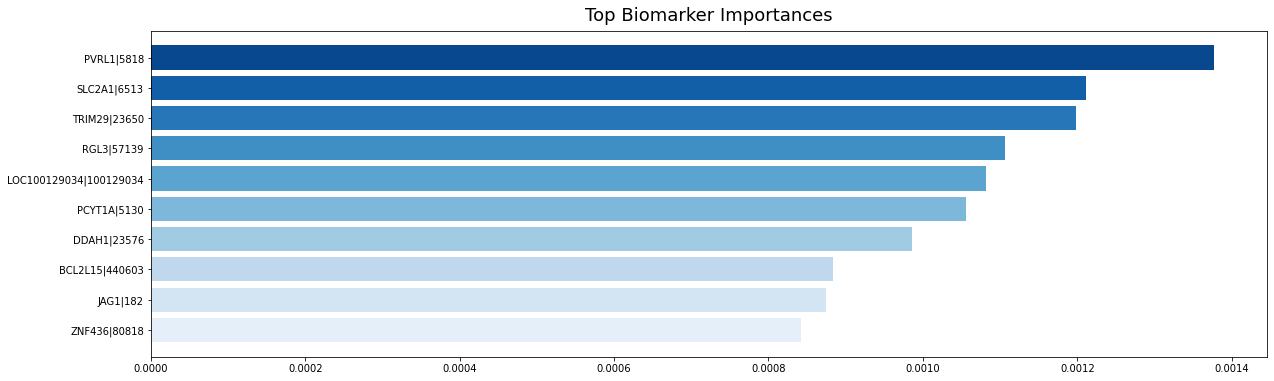

In [23]:
fig, ax = plt.subplots(figsize=(20,6))
sort_df = topDf[::-1]
colors = sns.color_palette('Blues', len(topDf))
bar = plt.barh(sort_df.index, sort_df['Top Biomarker'], color=colors)
ax.set_title("Top Biomarker Importances", pad=10, fontsize=18)
ax.set_yticklabels(sort_df.index, fontsize=10)
plt.show()

# Cancer Patients Comparison

In [24]:
# top biomarker
final_Clf = df[topDf.index]
cancer_sample = final_Clf.sample(n=20)
cancer_sample.shape

(20, 10)

In [25]:
df.loc[cancer_sample.index,'LUSC'].sort_values()

TCGA-55-7911-01A-11R-2170-07    0
TCGA-44-A47A-01A-21R-A24H-07    0
TCGA-55-6972-01A-11R-1949-07    0
TCGA-55-8090-01A-11R-2241-07    0
TCGA-55-6978-01A-11R-1949-07    0
TCGA-49-AAR3-01A-11R-A41B-07    0
TCGA-80-5611-01A-01R-1628-07    0
TCGA-L9-A50W-01A-12R-A39D-07    0
TCGA-77-7338-01A-11R-2045-07    1
TCGA-46-3767-01A-01R-0980-07    1
TCGA-33-6738-01A-11R-1949-07    1
TCGA-98-A539-01A-31R-A262-07    1
TCGA-66-2757-01A-01R-0851-07    1
TCGA-22-5483-01A-01R-1820-07    1
TCGA-22-4609-01A-21R-2125-07    1
TCGA-85-7696-01A-11R-2125-07    1
TCGA-77-8150-01A-11R-2247-07    1
TCGA-22-5480-01A-01R-1635-07    1
TCGA-90-7766-01A-21R-2125-07    1
TCGA-MF-A522-01A-11R-A262-07    1
Name: LUSC, dtype: uint8

In [26]:
cancer_idx = df.loc[cancer_sample.index,'LUSC'].sort_values().index 
final_Clf.loc[cancer_idx].head()

,PVRL1|5818,SLC2A1|6513,TRIM29|23650,RGL3|57139,LOC100129034|100129034,PCYT1A|5130,DDAH1|23576,BCL2L15|440603,JAG1|182,ZNF436|80818
TCGA-55-7911-01A-11R-2170-07,1303.5549,1895.5993,19.5586,922.7593,1435.2954,349.9405,2265.6271,464.6491,335.6680,242.9814
TCGA-44-A47A-01A-21R-A24H-07,2300.9212,1102.8659,56.2948,906.3511,1860.1894,288.6387,1715.4555,228.2497,600.8188,183.7257
TCGA-55-6972-01A-11R-1949-07,190.6393,178.0822,39.9543,605.0228,811.7123,133.5616,1592.4658,42.2374,686.0731,268.2648
TCGA-55-8090-01A-11R-2241-07,6357.0765,5911.7374,1264.1685,616.0731,3138.1728,344.3791,1546.6089,452.1524,1447.5070,322.3568
TCGA-55-6978-01A-11R-1949-07,311.9810,3853.2897,122.1265,186.4357,2222.1334,464.7292,1848.4695,162.4751,2369.0382,532.8174


In [27]:
final_Clf.loc[cancer_idx].describe()

,PVRL1|5818,SLC2A1|6513,TRIM29|23650,RGL3|57139,LOC100129034|100129034,PCYT1A|5130,DDAH1|23576,BCL2L15|440603,JAG1|182,ZNF436|80818
count,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000
mean,7438.830455,12052.413265,6129.339295,310.450715,1409.654540,676.876650,912.514390,111.959870,5158.961770,519.826675
std,7885.868086,13398.711544,7212.009990,428.747706,813.808017,533.048184,717.777744,160.462080,4562.116973,301.061087
min,190.639300,178.082200,19.558600,6.321100,470.153600,133.561600,114.334500,2.528400,240.245300,183.725700
25%,1301.346225,3363.867100,141.594325,35.198525,868.123025,348.550150,272.422050,11.967225,1257.148525,293.267150
50%,5808.953100,7942.371650,1283.984750,137.100150,1159.721750,501.312450,709.836100,26.053300,3723.468600,422.678000
75%,11203.055275,14239.055375,11697.011900,390.411200,1756.958650,842.689850,1583.735200,140.575250,7999.378125,630.675075
max,28172.545400,54980.921500,22343.845400,1649.048600,3494.297800,2163.786900,2265.627100,464.649100,14786.168600,1206.652300


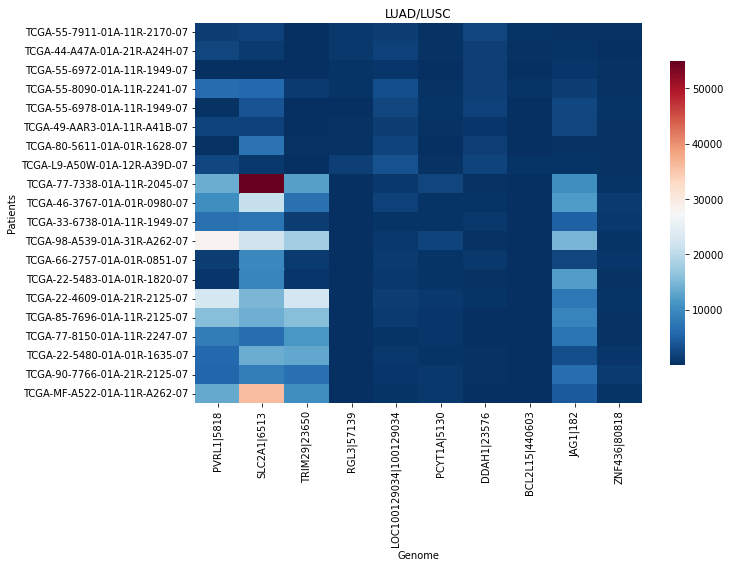

In [28]:
fig, ax = plt.subplots(figsize=(10,7))
sns.heatmap(final_Clf.loc[cancer_idx],
            cmap = 'RdBu_r',
            cbar_kws = {"shrink": .8}
            )
ax.set_xlabel('Genome')
ax.set_ylabel('Patients')
ax.set_title('LUAD/LUSC')
plt.show()